In [6]:
import pandas as pd
import numpy as np
%matplotlib inline 
import pickle
import scipy.stats
import ast
import glob

In [2]:
dumas = pd.read_csv("resultados_dumas.csv", sep=";", index_col=0)

In [3]:
dumas

,FWIN,ADWIN
re,0.98,1.00
cf,0.95,0.98
lp,1.00,1.00
pl,0.98,1.00
cb,0.84,0.92
cm,0.91,1.00
cp,1.00,1.00
cd,1.00,0.88
pm,1.00,1.00
rp,0.96,0.96


In [4]:
results = pd.read_csv("resultados_consolidados_2020-01-06.csv", sep=";", index_col = 0)

/home/ubuntu/.local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

In [10]:
dr = insensitive_glob("../drift_detection_results_v2/*/*/*.csv")

In [15]:
bases = []

for f in insensitive_glob("../drift_detection_results_v2/*/*/*.csv"):
    print(f, end="\r")
    bases.append(
        pd.read_csv(f, index_col=0, sep=";")
    )

In [16]:
results = pd.concat(bases)

In [17]:
results.to_csv("resultados_consolidados_2020-01-18_v2.csv", sep=";")

In [5]:
# results = pd.concat([
#     pd.read_excel("NOVO_resultados_agregados_sliding=False_agglomerative.xlsx", index_col=0),
#     pd.read_excel("NOVO_resultados_agregados_sliding=False.xlsx", index_col=0),
#     pd.read_excel("NOVO_resultados_agregados_sliding=True.xlsx", index_col=0),
#     pd.read_excel("NOVO_resultados_agregados_metricas_novas_representacoes_sliding=False.xlsx", index_col=0),
#     pd.read_excel("NOVO_resultados_agregados_metricas_novas_representacoes.xlsx", index_col=0),
#     pd.read_pickle("NOVO_resultados_agregados_exponential.pickle")
# ])

In [51]:
value = [2, 3, 2, 2, 1, 5, 10]

In [67]:
exp_mw_avg_std(value, 0.25)

(4.863421849686554, 3.9119751354048993)

In [68]:
exp_mw_avg_std_pandas(value, 0.25)

(4.863421849686554, 3.9119751354048993)

In [65]:
%timeit exp_mw_avg_std(value, a)

38.5 µs ± 267 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [66]:
%timeit exp_mw_avg_std_pandas(value, a)

1.53 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [57]:
a = 0.5

def exp_mw_avg_std(value, a):
    mrt_array = np.array(value)
    M = len(mrt_array)
    weights = (1-a)**np.arange(M-1, -1, -1) # This is reverse order to match Series order
    ewma = sum(weights * mrt_array) / sum(weights)
    bias = sum(weights)**2 / (sum(weights)**2 - sum(weights**2))
    ewmvar = bias * sum(weights * (mrt_array - ewma)**2) / sum(weights)
    ewmstd = np.sqrt(ewmvar)
    return ewma, ewmstd

In [62]:
def exp_mw_avg_std_pandas(value, a):
    value_pd = pd.Series(value).ewm(alpha=a, adjust=True)
    return value_pd.mean().values[-1], value_pd.std().values[-1]

In [56]:
ewma, ewmstd

(6.677165354330708, 4.396648858488916)

In [18]:
min_dumas = {}
for i, row in dumas.iterrows():
    min_dumas[i] = min(row["FWIN"], row["ADWIN"])

In [19]:
results["smooth_factor"] = results.smooth_factor.fillna(-1)

AttributeError: 'DataFrame' object has no attribute 'smooth_factor'

In [20]:
results = results.dropna()

In [21]:
# results["maior_igual_dumas"] = results.apply(
#     lambda x: 1 if x["F1"] >= min_dumas[x["tipo_mudanca"]] else 0,
#     axis=1
# )

In [22]:
len(results.tipo_mudanca.unique()) * 3

54

In [23]:
results.columns

Index(['tipo_mudanca', 'log_size', 'representation', 'window_size', 'model',
       'sliding_window', 'measure', 'detection_type', 'input',
       'rolling_window', 'std_tolerance', 'Precision', 'Recall', 'F1', 'Delay',
       'Correct_Predictions', 'Support', 'Drifts_Found', 'Resp'],
      dtype='object')

In [24]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [25]:
results = reduce_mem_usage(results)

Memory usage of dataframe is 431.15 MB
Memory usage after optimization is: 431.15 MB
Decreased by 0.0%


In [28]:
results = results[
    (results.detection_type == 'tradicional') &
    ~(results.representation.isin(['positions', 'max', 'avg'])) &
    (results.rolling_window < 5)
]

In [31]:
results.representation.value_counts()

binary         738720
tfidf          738720
transitions    738720
frequency      738720
Name: representation, dtype: int64

In [30]:
import gc
gc.collect()

81

In [38]:
grouped_means = results.groupby([
    "measure", "representation", "rolling_window", "sliding_window", "std_tolerance", "window_size", 
    "tipo_mudanca", "model", "detection_type"
]).agg({
    'F1': ['mean', "count"],
    'Delay': 'mean'
}).reset_index()

grouped_means.columns = [
    "measure", "representation", "rolling_window", "sliding_window", "std_tolerance", "window_size", 
    "tipo_mudanca", "model", "detection_type", "F1", "count", "mean_delay"
]

grouped_means = grouped_means.sort_values(['F1'], ascending=False)

In [42]:
grouped_means["count"].value_counts()

3    984960
Name: count, dtype: int64

In [50]:
grouped_means.drop_duplicates(["tipo_mudanca", "representation", "measure"]).to_csv("best_configuration_per_run_tipo_mudanca_and_representation.csv", sep=";")

In [128]:
grouped_means["F1=1"] = grouped_means["F1"].apply(lambda x: int(x == 1))

In [134]:
grouped_means.groupby(["measure", "tipo_mudanca"]).agg({"F1=1": sum, "F1": "mean"}).to_csv("measure_tipo_mudanca.csv", sep=";")

In [133]:
grouped_means.groupby(["representation", "tipo_mudanca"]).agg({"F1=1": sum, "F1": "mean"}).to_csv("rep_tipo_mudanca.csv", sep=";")

In [47]:
grouped_means[grouped_means.representation == "binary"].drop_duplicates("tipo_mudanca")

,measure,representation,rolling_window,sliding_window,std_tolerance,window_size,tipo_mudanca,model,detection_type,smooth_factor,mean_delay,F1,count
3871883,DIM__I_avg,binary,4,False,2.00,100,pm,kmeans__k=8,tradicional,-1.0,100.000000,1.000000,1
6413324,MSE__By_Phone,binary,3,False,2.25,150,cd,agglomerative__k=3_linkage=ward,tradicional,-1.0,150.000000,1.000000,1
7593067,cluster_std,binary,3,False,1.75,250,OIR,kmeans__k=6,tradicional,-1.0,250.000000,1.000000,1
7591415,cluster_std,binary,2,False,1.25,250,cf,agglomerative__k=8_linkage=ward,tradicional,-1.0,250.000000,1.000000,1
3871412,DIM__I_avg,binary,4,False,1.75,100,cb,agglomerative__k=6_linkage=ward,tradicional,-1.0,100.000000,1.000000,1
5075640,DIM__M_centroid_1,binary,3,False,2.25,200,RIO,kmeans__k=3,tradicional,-1.0,222.222222,1.000000,1
7242424,Silhouette,binary,4,False,1.75,150,ORI,kmeans__k=6,tradicional,-1.0,150.000000,1.000000,1
7597987,cluster_std,binary,4,False,1.75,200,IRO,kmeans__k=8,tradicional,-1.0,200.000000,1.000000,1
3866353,DIM__I_avg,binary,3,False,1.75,100,IOR,kmeans__k=8,tradicional,-1.0,111.111111,1.000000,1
5818291,DIM__O_centroid_4,binary,4,False,2.25,100,rp,agglomerative__k=8_linkage=ward,tradicional,-1.0,108.333333,0.962963,3


In [90]:
grouped_means_todos_tipos_mudanca = grouped_means.groupby([
    "measure", "representation", "rolling_window", "sliding_window", "std_tolerance", "window_size", 
    "model", "detection_type", "smooth_factor"
]).agg({'F1': 'mean', "count": "sum"}).reset_index()

grouped_means_todos_tipos_mudanca.columns = [
    "measure", "representation", "rolling_window", "sliding_window", "std_tolerance", "window_size", 
    "model", "detection_type", "smooth_factor", "F1", "count"
]

grouped_means_todos_tipos_mudanca = grouped_means_todos_tipos_mudanca.sort_values(['F1'], ascending=False)

In [96]:
grouped_means_todos_tipos_mudanca[grouped_means_todos_tipos_mudanca["count"] == 54].drop_duplicates(["measure"], keep="first").head(40)

,measure,representation,rolling_window,sliding_window,std_tolerance,window_size,model,detection_type,smooth_factor,F1,count
1370424,avg_dist_between_centroids,transitions,3,False,1.00,250,kmeans__k=8,tradicional,-1.0,0.723916,54
638916,DIM__H N_avg,transitions,3,False,1.00,250,agglomerative__k=6_linkage=ward,tradicional,-1.0,0.696496,54
1433398,diff_centroids,avg,3,False,1.00,250,agglomerative__k=3_linkage=ward_positions,tradicional,-1.0,0.694421,54
958336,DIM__N O_avg,transitions,3,False,1.00,250,agglomerative__k=6_linkage=ward,tradicional,-1.0,0.693924,54
1574789,skewness,transitions,3,False,1.25,250,agglomerative__k=6_linkage=ward,tradicional,-1.0,0.693313,54
2112,DBi,max,3,False,1.00,250,kmeans__k=3_positions_min,tradicional,-1.0,0.691164,54
1360964,Silhouette,transitions,3,False,1.00,250,agglomerative__k=6_linkage=ward,tradicional,-1.0,0.685728,54
1449367,dist_between_0_3,positions,3,False,1.00,250,kmeans__k=8,tradicional,-1.0,0.685451,54
900156,DIM__M O_avg,transitions,3,False,1.00,250,kmeans__k=8,tradicional,-1.0,0.683598,54
1444291,dist_between_0_2,frequency,3,False,1.00,250,kmeans__k=3,tradicional,-1.0,0.681171,54


In [93]:
grouped_means_todos_tipos_mudanca[grouped_means_todos_tipos_mudanca["count"] == 54]

,measure,representation,rolling_window,sliding_window,std_tolerance,window_size,model,detection_type,smooth_factor,F1,count
1370424,avg_dist_between_centroids,transitions,3,False,1.00,250,kmeans__k=8,tradicional,-1.0,0.723916,54
1370421,avg_dist_between_centroids,transitions,3,False,1.00,250,agglomerative__k=8_linkage=ward,tradicional,-1.0,0.710399,54
1370457,avg_dist_between_centroids,transitions,3,False,1.25,250,kmeans__k=8,tradicional,-1.0,0.710064,54
1370420,avg_dist_between_centroids,transitions,3,False,1.00,250,agglomerative__k=6_linkage=ward,tradicional,-1.0,0.708755,54
1370453,avg_dist_between_centroids,transitions,3,False,1.25,250,agglomerative__k=6_linkage=ward,tradicional,-1.0,0.705372,54
...,...,...,...,...,...,...,...,...,...,...,...
1158366,DIM__START_max_avg,max,3,True,1.00,150,agglomerative__k=3_linkage=ward_positions_min,tradicional,-1.0,0.000000,54
1158365,DIM__START_max_avg,max,3,True,1.00,100,kmeans__k=8_positions_min,tradicional,-1.0,0.000000,54
1158364,DIM__START_max_avg,max,3,True,1.00,100,kmeans__k=6_positions_min,tradicional,-1.0,0.000000,54
1158363,DIM__START_max_avg,max,3,True,1.00,100,kmeans__k=3_positions_min,tradicional,-1.0,0.000000,54


In [3]:
get_results_by_best_run(results, grouped_means_todos_tipos_mudanca[grouped_means_todos_tipos_mudanca["count"] == 54].drop_duplicates(["measure"], keep="first").head(40), 0)

NameError: name 'results' is not defined

In [2]:
def get_results_by_best_run(results, best_runs, i=0):
    return results[
        (results.measure == best_runs.iloc[i].measure) &
        (results.rolling_window == best_runs.iloc[i].rolling_window) &
        (results.sliding_window == best_runs.iloc[i].sliding_window) &
        (results.std_tolerance == best_runs.iloc[i].std_tolerance) &
        (results.window_size == best_runs.iloc[i].window_size) &
        (results.smooth_factor == best_runs.iloc[i].smooth_factor) &
        (results.model == best_runs.iloc[i].model)
    ]

In [121]:
best_runs = grouped_means_todos_tipos_mudanca[
    (grouped_means_todos_tipos_mudanca["count"] > 3) & 
    (grouped_means_todos_tipos_mudanca["count"] < 54)
]

In [122]:
grouped_means_todos_tipos_mudanca["count"].value_counts()

54    667960
3     358416
27     72059
30     65073
33     63092
24     51472
6      47024
51     43656
39     35920
36     35000
12     32464
48     29360
45     26116
21     25288
42     21416
9      12368
18     10200
15      9692
Name: count, dtype: int64

In [123]:
best_runs = best_runs.drop_duplicates(["measure", "representation"], keep="first")

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


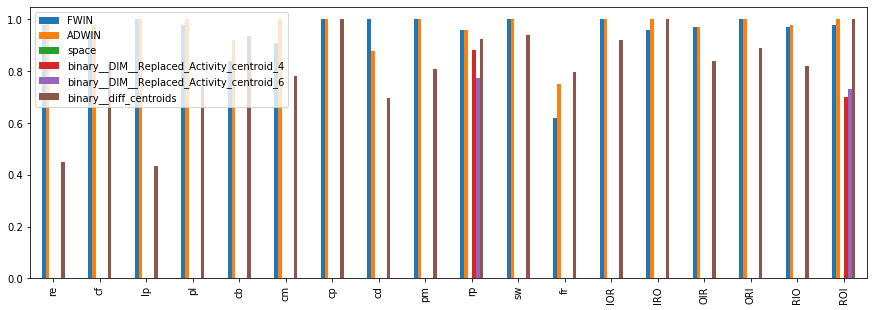

In [124]:
dumas = dumas[["FWIN", "ADWIN"]].copy()

dumas["space"] = [0 for x in dumas.index]

test = get_results_by_best_run(results, best_runs, 0).groupby("tipo_mudanca").F1.mean()
dumas[
    best_runs.iloc[0].representation + "__" + best_runs.iloc[0].measure
] = test.loc[dumas.index]

test = get_results_by_best_run(results, best_runs, 1).groupby("tipo_mudanca").F1.mean()
dumas[
    best_runs.iloc[1].representation + "__" + best_runs.iloc[1].measure
] = test.loc[dumas.index]

test = get_results_by_best_run(results, best_runs, 2).groupby("tipo_mudanca").F1.mean()
dumas[
    best_runs.iloc[2].representation + "__" + best_runs.iloc[2].measure
] = test.loc[dumas.index]

dumas.plot(kind='bar', figsize=(15, 5))

In [71]:
best_runs.head()

,measure,representation,rolling_window,sliding_window,std_tolerance,window_size,model,detection_type,smooth_factor,F1,maior_igual_dumas
15846,diff_centroids,positions,4.0,0.0,2.00,150.0,kmeans__k=3,tradicional,-1.0,0.567517,15
4448,avg_dist_between_centroids,transitions,4.0,0.0,1.25,150.0,kmeans__k=3,tradicional,-1.0,0.454831,13
32431,dist_intra_cluster,transitions,4.0,0.0,1.25,200.0,kmeans__k=6,tradicional,-1.0,0.440419,11
13662,diff_avg_dist_between_centroids,frequency,4.0,0.0,1.25,200.0,kmeans__k=3,tradicional,-1.0,0.511749,10
2479,Silhouette,transitions,4.0,0.0,2.00,150.0,kmeans__k=6,tradicional,-1.0,0.419059,9


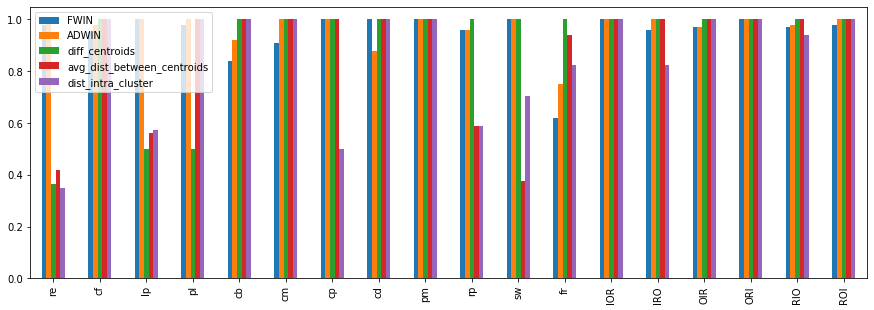

In [72]:
dumas = dumas[["FWIN", "ADWIN"]].copy()

test = get_results_by_best_run(results, best_runs[best_runs.measure == "diff_centroids"], 0).groupby("tipo_mudanca").F1.max()
dumas["diff_centroids"] = test.loc[dumas.index]

test = get_results_by_best_run(results, best_runs[best_runs.measure == "avg_dist_between_centroids"], 0).groupby("tipo_mudanca").F1.max()
dumas["avg_dist_between_centroids"] = test.loc[dumas.index]

test = get_results_by_best_run(results, best_runs[best_runs.measure == "dist_intra_cluster"], 0).groupby("tipo_mudanca").F1.max()
dumas["dist_intra_cluster"] = test.loc[dumas.index]

dumas.plot(kind='bar', figsize=(15, 5))

In [99]:
import gc
gc.collect()

0